<html>
    <head>
        <title>Sample data Preview</title>
        <!-- colors {
        green: #60b24b,
        blue_light: #52a29b,
        blue: #3d74c9,
        purple: #6244d5,
        red: #b44e4e,
        yellowish: #9b9948
}
//-->
    </head>
    <body>
        <div class="navigation">
            <ul id='1' style="margin-bottom:5%;text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b">Exploring Sample Data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9">Visualizing the data </li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#b44e4e">Performing a dataset cleanup</li>
            </ul>
            <ul id='2' style="text-align:center;">
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#60b24b"> Building the mode</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#3d74c9"> Internal Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#52a29b"> External Validation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#6244d5"> Interpretation</li>
                <li style="display:inline;margin-right:5%;padding:2%;background-color:#dddddd;color:#9b9948">Prediction</li>
            </ul>
        </div>
    </body>
</html>

# **Libraries and Frameworks**

In [1]:
# Installing libraries
import sys
if 'google.colab' in sys.modules:
    !pip install scikit-plot
    !pip install shap
    !pip install CHAID
else:
    print('Please install scikit-plot, shape and CHAID libraries using the following commands:\n')
    print('pip install scikit-plot')
    print('pip install shap')
    print('pip install CHAID')

In [0]:
import numpy as np
import pandas as pd
import shap

import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Other
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.metrics import r2_score #R-squared


# Optional, same as LogisticRegression or LinearRegression
import statsmodels.api as sm #statsmodels library
from statsmodels.discrete.discrete_model import Logit

#libraries for modelling and evaluation
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from CHAID import Tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score,roc_curve # ... 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score
import scikitplot as skplt #in case of error run "pip install scikit-plot" in cmd(terminal) and run the code again

In [3]:
# Checking Runtime Environment and importing data
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = "/content/drive/My Drive/sample_data.csv"
else:
    dataset_path = "./Desktop/BA_Group_Project_Analysis/sample_data.csv"

data = pd.read_csv(dataset_path)

data_numbers = data.select_dtypes(exclude=['object']) # Will be used for working with int/float values
data_objects = data.select_dtypes(include=['object']) # Will be used for working with strings/objects values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preview**

In [4]:
# Taking a look at the data
print('Shape: ', data.shape, '\n---------------------------------------------')

print('Head: \n',data.head(), '\n---------------------------------------------')
print('Summary: \n',data.describe(), '\n---------------------------------------------')

Shape:  (27420, 131) 
---------------------------------------------
Head: 
    ARV17_MINUS_ARV16  AXM4970T  AXM4971T  ...  STATE_CD  XFC06  XFC07
0            11108.0       7.0        10  ...        CA    3.0    0.0
1              182.0       7.0        14  ...        TX    0.0    1.0
2             5342.0       7.0        14  ...        NY    0.0    0.0
3               85.0       3.0         5  ...        IN    0.0    1.0
4             2245.0       5.0         9  ...        MO    0.0    0.0

[5 rows x 131 columns] 
---------------------------------------------
Summary: 
        ARV17_MINUS_ARV16      AXM4970T  ...         XFC06         XFC07
count       27420.000000  27420.000000  ...  27420.000000  27420.000000
mean         9400.773924      6.664734  ...      2.024252      0.186142
std          9657.697012      2.711635  ...      3.210141      0.658014
min        -18694.000000      0.000000  ...      0.000000      0.000000
25%          3073.500000      5.000000  ...      0.000000     

In [5]:
print('Columns: ',data.columns, '\n---------------------------------------------')
print('Data types:\n\n',data.dtypes.value_counts(), '\n---------------------------------------------')

Columns:  Index(['ARV17_MINUS_ARV16', 'AXM4970T', 'AXM4971T', 'AXM5030T', 'AXM5032T',
       'AXM5130T', 'AXM5131T', 'AXM5930T', 'AXM5931T', 'AXM5932T',
       ...
       'SMARTV40_CRM01', 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06',
       'SMARTV40_DDT01', 'SMARTV40_DDT02', 'SMARTV40_DDT18', 'STATE_CD',
       'XFC06', 'XFC07'],
      dtype='object', length=131) 
---------------------------------------------
Data types:

 float64    111
object      11
int64        9
dtype: int64 
---------------------------------------------


In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 19
Missing values: 152691
Single valued columns: Index([], dtype='object')


In [7]:
# Issues with data
#   Data has outliers
#   Data has missing values
#   Data includes columns with unique values

# Shows columns with missing values
print("Missing Values\n\n", data.isna().sum()[data.isna().sum() > 0], 
      '\n-------------------------') # 152,691

# Shows columns with Unique Values
print("Unique Values\n")
for column in data_objects:
  data_column = data_objects[column]
  print(column + ": ",data_column.value_counts().count())
print('-------------------------')

Missing Values

 DEM08                11
SMARTV40_CMG04    23605
SMARTV40_CMG05    26796
SMARTV40_CRM01    27065
SMARTV40_CRN01    26716
SMARTV40_CRT01    22528
SMARTV40_CRT06    25970
dtype: int64 
-------------------------
Unique Values

DEM03:  4
DEM06:  3
DEM08:  13
ENCRYPTED_PIN:  27316
KEYID:  27315
SEGMENT_CODE:  7
SMARTV40_AAU19:  18
SMARTV40_AAU20:  13
SMARTV40_AAU22:  12
SMARTV40_ALE21:  12
STATE_CD:  30
-------------------------


In [8]:
# Shows columns with outliers
def show_outliers(dataset):
  print("Outliers\n")
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
      data_column = data[column]
      outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
      if (len(outliers) < 20) and (len(outliers) != 0):
        print(outliers, '\n------------------------------')

show_outliers(data)

# Columns with negative values
data_mins = data.select_dtypes(exclude='object').min()
columns_with_negatives = data_mins[data_mins < 0].keys()
for column in columns_with_negatives:
  print('Column Name: ', column)
  print('Positives: ', (data[column] < 0).value_counts()[0])
  print('Negatives: ', (data[column] < 0).value_counts()[1])
  print('-------------------------')

Outliers

3391    96.0
Name: AXM4970T, dtype: float64 
------------------------------
1365      0
3391     96
3713      0
5142      0
7320      0
14594     0
17271     0
27211     0
Name: AXM4971T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5030T, dtype: int64 
------------------------------
3391    999999996
Name: AXM5032T, dtype: int64 
------------------------------
3391    999999996.0
Name: AXM5130T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5131T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5930T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5931T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5932T, dtype: float64 
------------------------------
3391    999999996.0
Name: AXM5933T, dtype: float64 
------------------------------
3391    96.0
Name: AXM8131T, dtype: float64 
------------------------------
3391     96.0
23914    97

In [0]:
# Conclusion:
#   Missing values in SMARTV40_CR..., SMARTV40_CM... and 11 in DEM08.
#   Outliers with values 999999996, 999999997, 96, 97 will have to be removed.
#   columns SMARTV40_ART18 and AXM4970T have large outliers (in AXM4970T 0 is an outlier).
#   columns ENCRYPTED_PIN and KEYID have too many unique values and have to be removed.
#   Drop XFC06, XFC07 and SEGMENT_CODE. EXP_ID ?

RESPONSE_FLAG    2
dtype: int64


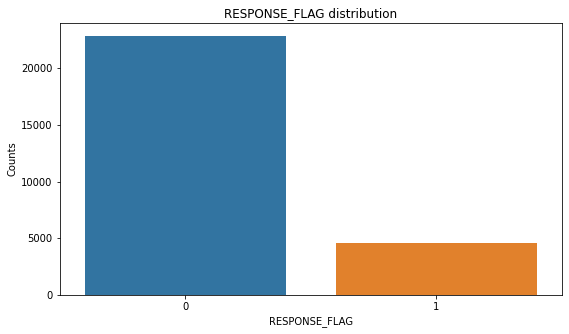

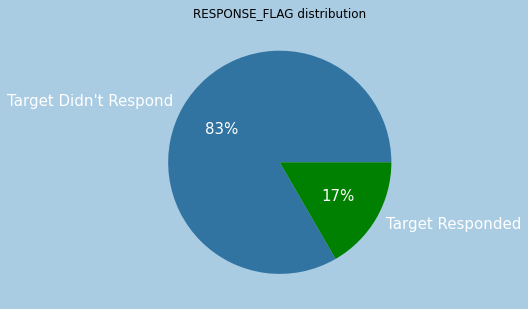


Values with Correlation Above 90%


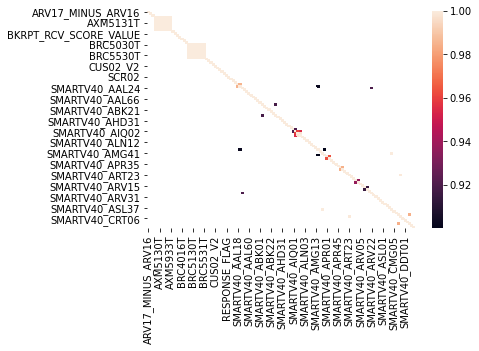


Missing Values Per Flag
0: 
 DEM08                10
SMARTV40_CMG04    19731
SMARTV40_CMG05    22349
SMARTV40_CRM01    22557
SMARTV40_CRN01    22228
SMARTV40_CRT01    18877
SMARTV40_CRT06    21674
dtype: int64
1: 
 DEM08                1
SMARTV40_CMG04    3874
SMARTV40_CMG05    4447
SMARTV40_CRM01    4508
SMARTV40_CRN01    4488
SMARTV40_CRT01    3651
SMARTV40_CRT06    4296
dtype: int64


In [10]:
# Exploring the Target

# Finding the Target variable
print(data.nunique()[data.nunique() == 2])

#let's visualise the distribution of flags
plt.figure(figsize=(9,5))
sns.countplot(data.RESPONSE_FLAG)
plt.title("RESPONSE_FLAG distribution")
plt.ylabel('Counts')
plt.show()

pie_chart = plt.figure(figsize=(5,8))
plt.pie(data.RESPONSE_FLAG.value_counts(normalize=True).mul(100).rename("RESPONSE_FLAG percentages"),
        labels=["Target Didn't Respond", 'Target Responded'], colors=['#3274a1', 'green'], 
         autopct='%1.0f%%', textprops={'color':"w", 'fontsize': 15})
plt.title("RESPONSE_FLAG distribution")
pie_chart.patch.set_facecolor('#A9CCE3')
plt.show()
print('\nValues with Correlation Above 90%')
sns.heatmap(data.corr().abs()[data.corr().abs() >= 0.90])
plt.show()
print()

print('Missing Values Per Flag')
print('0: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 0].isna().sum())
print('1: \n', data[data.isna().sum()[data.isna().sum() > 0].keys()][data['RESPONSE_FLAG'] == 1].isna().sum())

# **CHAID for grouping States**

In [0]:
# Setting variables
independent_variable_columns = ['STATE_CD']
dep_variable = 'RESPONSE_FLAG'

#Creating the tree
tree = Tree.from_pandas_df(data[['STATE_CD', 'RESPONSE_FLAG']], dict(zip(independent_variable_columns, ['nominal'] * 3)), dep_variable)

CHAID_groups= eval(tree.tree_store[0].split.groupings)

In [15]:
CHAID_groups

[['AK', 'LA', 'MO', 'NM', 'IN', 'MD', 'AR', 'MT', 'SD', 'PA'],
 ['AL', 'NY', 'DC', 'MA', 'MI'],
 ['AZ', 'TX', 'KY', 'VA', 'FL', 'NC', 'OK'],
 ['CA', 'NE'],
 ['MS', 'WI'],
 ['NJ', 'NV', 'TN'],
 ['SC']]

# **Useful Functions**

In [0]:
# Useful Functions 
def model_performance(X0, X1, Y0, Y1, model):
    
    Y0_predict = model.predict(X0)
    Y1_predict = model.predict(X1)
    
    Y0_hat = model.predict_proba(X0)[:,1]
    Y1_hat = model.predict_proba(X1)[:,1]

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_predict))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_predict))
    print('-------------------------')

def logit_model_performance(X0, X1, Y0, Y1, model):
    
    Y0_hat = model.predict(X0)
    Y1_hat = model.predict(X1)
    Y0_class = np.where(Y0_hat>0.5, 1, 0)
    Y1_class = np.where(Y1_hat>0.5, 1, 0)

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1,Y1_hat).round(3))
    print('-------------------------')
    print('\nClassification Report Train')
    print(classification_report(Y0,Y0_class))
    print('-------------------------')
    print('\nClassification Report Test')
    print(classification_report(Y1,Y1_class))
    print('-------------------------')

# Outputs the columns that need to be dropped
def to_drop(dataset, corr_threshold):
  # Create correlation matrix
  corr_matrix = dataset.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find index of feature columns with correlation greater than corr_threshold
  drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]

  drop = drop + ['EXP_ID','ENCRYPTED_PIN','KEYID', 'XFC06', 'XFC07', 'SEGMENT_CODE',
                 'SEQNUM',
                 'SMARTV40_CMG04', 'SMARTV40_CMG05', 'SMARTV40_CRM01', 
                 'SMARTV40_CRN01', 'SMARTV40_CRT01', 'SMARTV40_CRT06'
                 ]
  return drop

# Drops the outliers from the dataset 
def drop_outliers(dataset):
  for column in dataset.select_dtypes(exclude=['uint8', 'object']):
    data_column = dataset[column]
    outliers = data_column[((data_column - data_column.mean()) / data_column.std()).abs() > 3]
    if (len(outliers) < 20) and (len(outliers) != 0):
      dataset[column] = data_column[((data_column - data_column.mean()) / data_column.std()).abs() < 3]

# For CHAID groups
def group_states(state):
    for i in range(len(CHAID_groups)):
        if state in CHAID_groups[i]:
            return 'Group_'+ str(i)

# Outputs data ready for use
def clean_data (dataset, drop_columns):                         
  new_data = dataset.drop(columns=drop_columns)

  drop_outliers(new_data)

  new_data['STATE_CD'] =  new_data['STATE_CD'].apply(group_states)

  new_data = pd.get_dummies(new_data,drop_first=True)

  new_data = new_data.dropna() # removes 11 rows. The missing values in DEM03.

  return new_data

# shorter version, to avoid typing test_size and random_state
def tt_split_results(X, Y):
    return train_test_split(X, Y, test_size=0.25, random_state=42)

# Separates target from features
def get_target_and_features(dataset):
    # X and Y
    Y = dataset["RESPONSE_FLAG"]
    X = dataset.drop("RESPONSE_FLAG",axis=1)
    X =  sm.add_constant(X)
    return (X, Y)

# RFE for with n_features for the model
def best_features(model, n_features, X0, Y0):
    estimator = model
    selector =  RFE(estimator, n_features, step=1)
    selector.fit(X0, Y0)
    n_feature_rankings = 1
    best_features = X0.columns[selector.ranking_ <= n_feature_rankings]
    return best_features

# learining curve
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# **Cleanup**

In [0]:
#Let's setup the data for processing
also_dropping = ['SMARTV40_AAU19','SMARTV40_AAU20',
                 'SMARTV40_AAU22','SMARTV40_ALE21',
                 'DEM03']

cols_dropped_1 = to_drop(data, 1)

cols_dropped_2 = to_drop(data, 0.99)

cols_dropped_3 = to_drop(data, 0.98)

cols_dropped_4 = to_drop(data, 0.95)

cols_dropped_5 = to_drop(data, 0.9)

cols_dropped_6 = to_drop(data, 0.9) + also_dropping
cols_dropped_7 = to_drop(data, 0.85)

cols_dropped_8 = to_drop(data, 0.85) + also_dropping
cols_dropped_9 = to_drop(data, 0.8)

cols_dropped_10 = to_drop(data, 0.8) + also_dropping


cleanup_methods = [cols_dropped_1, cols_dropped_2, cols_dropped_3, cols_dropped_4,
                   cols_dropped_5, cols_dropped_6, cols_dropped_7, cols_dropped_8,
                   cols_dropped_9, cols_dropped_10]

# **Cleanup Preview**

Data Before


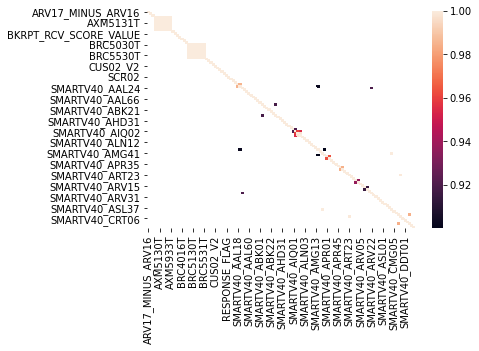

Data After


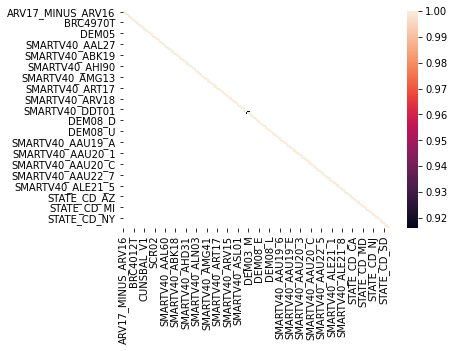

In [13]:
# 90% cleanup
clean_top = clean_data(data,to_drop(data, 0.9))

print('Data Before')
sns.heatmap(data.corr().abs()[data.corr().abs() > 0.9])
plt.show()

print('Data After')
sns.heatmap(clean_top.corr().abs()[clean_top.corr().abs() > 0.9])
plt.show()

In [102]:
# CHAID Split
clean_data(data,cleanup_methods[8]).tail()

,ARV17_MINUS_ARV16,AXM4970T,AXM5030T,AXM8131T,BKRPT_RCV_SCORE_VALUE,BRC4003T,BRC4012T,BRC4016T,BRC4970T,BRC4971T,BRC5030T,BRC8131T,CUNSAGE_V1,CUNSBAL_V1,CUNSINQ_V1,CUS02_V2,CUS07_REV120_V1,DEM05,HOMEEQUITY_HEQ09,RESPONSE_FLAG,SCR02,SCR16,SMARTV40_AAL01,SMARTV40_AAL18,SMARTV40_AAL24,SMARTV40_AAL25,SMARTV40_AAL27,SMARTV40_AAL61,SMARTV40_AAL66,SMARTV40_AAU13,SMARTV40_ABK01,SMARTV40_ABK05,SMARTV40_ABK18,SMARTV40_ABK19,SMARTV40_ABK21,SMARTV40_ABK22,SMARTV40_ABK23,SMARTV40_ABK35,SMARTV40_AHD11,SMARTV40_AHD31,...,SMARTV40_AAU20_1,SMARTV40_AAU20_2,SMARTV40_AAU20_3,SMARTV40_AAU20_4,SMARTV40_AAU20_5,SMARTV40_AAU20_6,SMARTV40_AAU20_7,SMARTV40_AAU20_A,SMARTV40_AAU20_B,SMARTV40_AAU20_C,SMARTV40_AAU20_D,SMARTV40_AAU20_E,SMARTV40_AAU22_1,SMARTV40_AAU22_2,SMARTV40_AAU22_3,SMARTV40_AAU22_4,SMARTV40_AAU22_5,SMARTV40_AAU22_6,SMARTV40_AAU22_7,SMARTV40_AAU22_8,SMARTV40_AAU22_9,SMARTV40_AAU22_A,SMARTV40_AAU22_B,SMARTV40_ALE21_1,SMARTV40_ALE21_2,SMARTV40_ALE21_3,SMARTV40_ALE21_4,SMARTV40_ALE21_5,SMARTV40_ALE21_6,SMARTV40_ALE21_7,SMARTV40_ALE21_8,SMARTV40_ALE21_9,SMARTV40_ALE21_A,SMARTV40_ALE21_B,STATE_CD_Group_1,STATE_CD_Group_2,STATE_CD_Group_3,STATE_CD_Group_4,STATE_CD_Group_5,STATE_CD_Group_6
27415,5410.0,2.0,926.0,24.0,563.0,0.0,24.0,24.0,8.0,14,681.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,87900.0,0,584.0,675.0,27.0,299321.0,298.0,2.0,107.0,10.0,3.0,2.0,7.0,2.0,87.0,24650.0,99.0,287.0,7.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
27416,13385.0,4.0,8979.0,10.0,595.0,0.0,24.0,23.0,3.0,10,2424.0,12.0,0.0,0.0,0.0,0.0,0.0,27.0,30000.0,0,663.0,689.0,29.0,164453.0,388.0,4.0,127.0,12.0,2.0,11.0,8.0,5.0,75.0,11761.0,85.0,388.0,23.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27417,6236.0,11.0,15956.0,0.0,154.0,0.0,5.0,7.0,11.0,18,17630.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,847.0,626.0,19.0,84161.0,73.0,6.0,31.0,16.0,2.0,17.0,6.0,6.0,80.0,9649.0,96.0,73.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
27418,57712.0,4.0,16272.0,4.0,269.0,0.0,23.0,24.0,9.0,13,14622.0,0.0,0.0,0.0,155.0,0.0,0.0,17.0,0.0,1,9999.0,649.0,99.0,262906.0,253.0,3.0,78.0,28.0,4.0,30.0,41.0,17.0,69.0,10710.0,94.0,253.0,12.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
27419,11505.0,5.0,8202.0,10.0,220.0,0.0,22.0,24.0,9.0,16,8952.0,0.0,590.0,4501.0,173.0,0.0,0.0,30.0,0.0,1,1062.0,534.0,52.0,111540.0,153.0,1.0,41.0,33.0,2.0,11.0,11.0,9.0,88.0,3773.0,100.0,151.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# **Logistic regression**

In [0]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))

# Feature Engineering

# X_final['Diff_2'] = (data_2['ARV17_MINUS_ARV16'].apply(lambda x: 0 if x > 0 else 1)) * data_2['ARV17_MINUS_ARV16'].abs()
# X_final['Diff_1'] = data_2.EXP_ID.apply(lambda x: 0 if x==60 else 1) * data_2.EXP_ID

X0, X1, Y0, Y1 = tt_split_results(X, Y)

logit_model_statsmodels = Logit(Y0, X0).fit()

logit_model_performance(X0, X1, Y0, Y1, logit_model_statsmodels)

In [104]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering

X0, X1, Y0, Y1 = tt_split_results(X, Y)

logit_model_1 = LogisticRegression(random_state=42).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, logit_model_1)


ROC AUC Train 0.633
ROC AUC Test 0.649
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     17137
           1       0.35      0.02      0.04      3417

    accuracy                           0.83     20554
   macro avg       0.59      0.51      0.47     20554
weighted avg       0.76      0.83      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      5701
           1       0.49      0.02      0.04      1151

    accuracy                           0.83      6852
   macro avg       0.66      0.51      0.48      6852
weighted avg       0.78      0.83      0.76      6852

-------------------------


In [0]:
logit_best = best_features(LogisticRegression(random_state=42), 37, X0, Y0)

In [203]:
print('best_features_logit: ', logit_best, '\n')
logit_model_2 = LogisticRegression(random_state=42).fit(X0[logit_best],Y0)
model_performance(X0[logit_best], X1[logit_best], Y0, Y1, logit_model_2)

best_features_logit:  Index(['AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T', 'BRC4016T', 'BRC4971T',
       'BRC8131T', 'CUNSAGE_V1', 'SCR02', 'SCR16', 'SMARTV40_AAL01',
       'SMARTV40_AAL24', 'SMARTV40_AAL25', 'SMARTV40_AAL27', 'SMARTV40_AAL61',
       'SMARTV40_AAL66', 'SMARTV40_AAU13', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK21', 'SMARTV40_ABK22', 'SMARTV40_ABK23',
       'SMARTV40_ALN12', 'SMARTV40_AMG13', 'SMARTV40_APR30', 'SMARTV40_APR45',
       'SMARTV40_ART18', 'SMARTV40_ART23', 'SMARTV40_ARV16', 'SMARTV40_ARV23',
       'SMARTV40_ARV31', 'SMARTV40_ASL01', 'SMARTV40_ASL14', 'SMARTV40_ASL37',
       'SMARTV40_DDT01', 'SMARTV40_DDT02', 'STATE_CD_Group_3'],
      dtype='object') 


ROC AUC Train 0.668
ROC AUC Test 0.65
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     17137
           1       0.46      0.03      0.06      3417

    accur

In [204]:
param_logit={'C':np.linspace(0,3,10),
             'class_weight': ['balanced', None]
             }

gridsearch = GridSearchCV(estimator=LogisticRegression(random_state=42),
                        param_grid=param_logit,
                        cv=5,scoring='roc_auc',verbose=1, n_jobs=-1)

gridsearch.fit(X0[logit_best], Y0)
best_model_params = gridsearch.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.0s finished


In [205]:
best_model_params

{'C': 1.0, 'class_weight': 'balanced'}

In [217]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))

# Feature Engineering

X0, X1, Y0, Y1 = tt_split_results(X, Y)

# scaler = preprocessing.MinMaxScaler()

# scaler.fit(X0)

# X0= scaler.transform(X0)

# X1 = scaler.transform(X1)

# le = preprocessing.LabelEncoder()
# le.transform(X0[something])
# le.transform(X1[something])

logit_model_3 = LogisticRegression(C = 1.3, class_weight = 'balanced',random_state=42,fit_intercept=True).fit(X0[logit_best],Y0)
model_performance((X0[logit_best]), X1[logit_best], Y0, Y1, logit_model_3)


ROC AUC Train 0.675
ROC AUC Test 0.658
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.89      0.66      0.76     17137
           1       0.26      0.59      0.36      3417

    accuracy                           0.65     20554
   macro avg       0.58      0.63      0.56     20554
weighted avg       0.79      0.65      0.69     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.88      0.66      0.76      5701
           1       0.25      0.57      0.35      1151

    accuracy                           0.65      6852
   macro avg       0.57      0.61      0.55      6852
weighted avg       0.78      0.65      0.69      6852

-------------------------


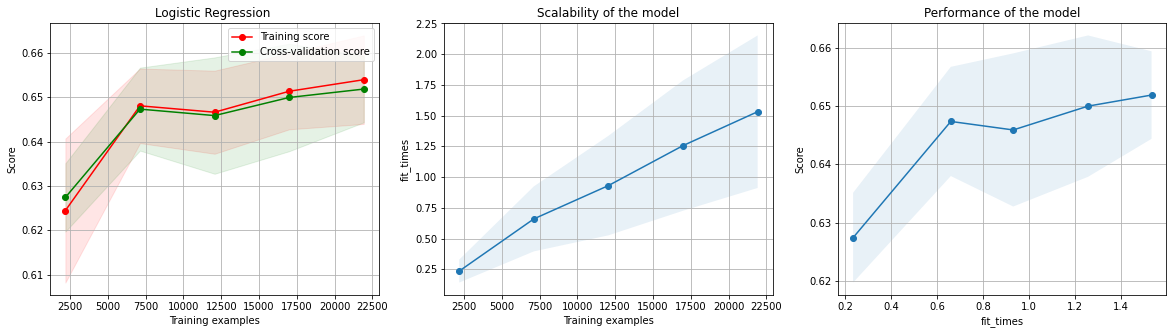

In [218]:
title = 'Logistic Regression '
plot_learning_curve(logit_model_3, title, X[logit_best], Y,
                    cv=5, n_jobs=-1)
plt.show()

In [0]:
cv_scores=cross_val_score(logit_model_3,X[logit_best],Y,cv=5,scoring="roc_auc")

In [221]:
print('cv_scores: ', cv_scores)
print('cv_score: ', np.mean(cv_scores).round(2))

cv_scores:  [0.66441581 0.68215411 0.68113818 0.67517257 0.66489357]
cv_score:  0.67


best_features_logit:  Index(['AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T', 'BRC4016T', 'BRC4971T',
       'BRC8131T', 'CUNSAGE_V1', 'SCR02', 'SCR16', 'SMARTV40_AAL01',
       'SMARTV40_AAL24', 'SMARTV40_AAL25', 'SMARTV40_AAL27', 'SMARTV40_AAL61',
       'SMARTV40_AAL66', 'SMARTV40_AAU13', 'SMARTV40_ABK01', 'SMARTV40_ABK05',
       'SMARTV40_ABK18', 'SMARTV40_ABK21', 'SMARTV40_ABK22', 'SMARTV40_ABK23',
       'SMARTV40_ALN12', 'SMARTV40_AMG13', 'SMARTV40_APR30', 'SMARTV40_APR45',
       'SMARTV40_ART18', 'SMARTV40_ART23', 'SMARTV40_ARV16', 'SMARTV40_ARV23',
       'SMARTV40_ARV31', 'SMARTV40_ASL01', 'SMARTV40_ASL14', 'SMARTV40_ASL37',
       'SMARTV40_DDT01', 'SMARTV40_DDT02', 'STATE_CD_Group_3'],
      dtype='object') 



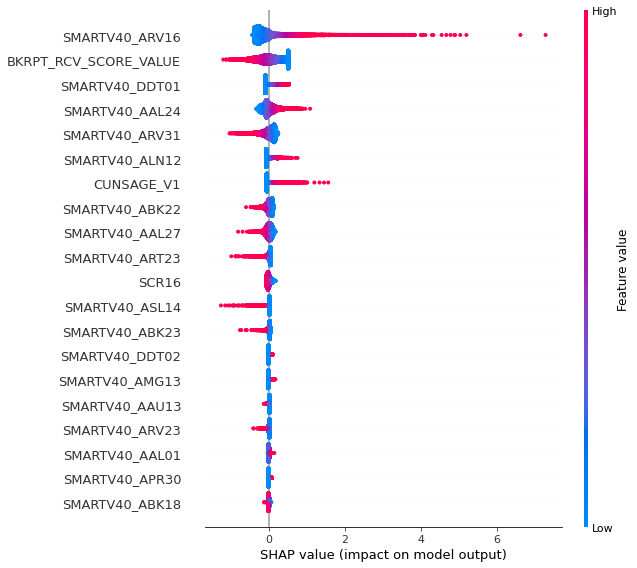

In [222]:
print('best_features_logit: ', logit_best, '\n')
shap_values = shap.LinearExplainer(logit_model_3, X[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best])

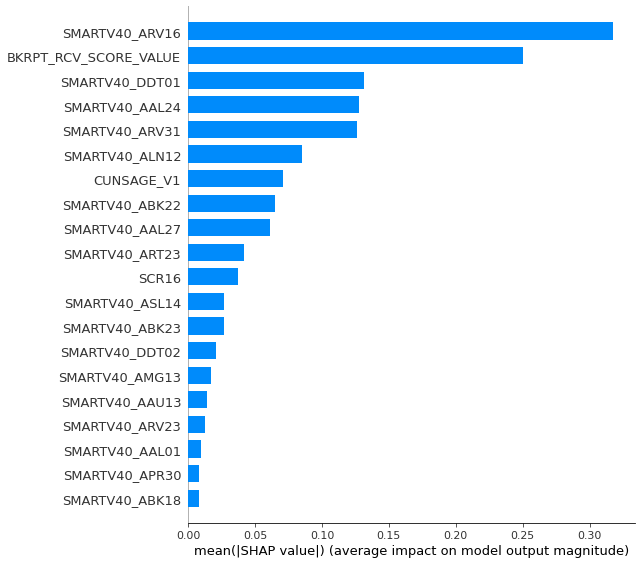

In [223]:
# Explaining the model with SHAP
shap_values = shap.LinearExplainer(logit_model_3, X[logit_best]).shap_values(X0[logit_best])
shap.summary_plot(shap_values, X0[logit_best], plot_type="bar")


# **Decision Tree**

In [224]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

dt_1 = DecisionTreeClassifier(random_state=42)
dt_1.fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, dt_1)


ROC AUC Train 1.0
ROC AUC Test 0.596
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17137
           1       1.00      1.00      1.00      3417

    accuracy                           1.00     20554
   macro avg       1.00      1.00      1.00     20554
weighted avg       1.00      1.00      1.00     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5701
           1       0.32      0.34      0.33      1151

    accuracy                           0.77      6852
   macro avg       0.59      0.60      0.59      6852
weighted avg       0.77      0.77      0.77      6852

-------------------------


In [0]:
dt_best = best_features(DecisionTreeClassifier(random_state=42), 35, X0, Y0)

In [262]:
dt_best

Index(['ARV17_MINUS_ARV16', 'AXM4970T', 'AXM5030T', 'BKRPT_RCV_SCORE_VALUE',
       'BRC4012T', 'BRC5030T', 'BRC8131T', 'CUNSBAL_V1', 'CUNSINQ_V1', 'DEM05',
       'SCR02', 'SCR16', 'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL24',
       'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_AAU13',
       'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19', 'SMARTV40_ABK21',
       'SMARTV40_ABK22', 'SMARTV40_ABK23', 'SMARTV40_AIN17', 'SMARTV40_ALN12',
       'SMARTV40_ALN13', 'SMARTV40_AMG13', 'SMARTV40_ART17', 'SMARTV40_ART18',
       'SMARTV40_ART23', 'SMARTV40_ARV16', 'SMARTV40_ARV31', 'SMARTV40_ARV34'],
      dtype='object')

In [263]:
dt_2 = DecisionTreeClassifier(class_weight=None, max_depth=6, min_samples_leaf=128, random_state=42)
dt_2.fit(X0[dt_best],Y0)
model_performance(X0[dt_best], X1[dt_best], Y0, Y1, dt_2)


ROC AUC Train 0.76
ROC AUC Test 0.742
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     17137
           1       0.72      0.10      0.17      3417

    accuracy                           0.84     20554
   macro avg       0.78      0.54      0.54     20554
weighted avg       0.83      0.84      0.79     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      5701
           1       0.59      0.07      0.13      1151

    accuracy                           0.84      6852
   macro avg       0.72      0.53      0.52      6852
weighted avg       0.80      0.84      0.78      6852

-------------------------


In [264]:
param_dt={'max_depth': range(4,9),
          'min_samples_leaf': range(0,200,15)
          }
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_dt,
                  scoring="roc_auc",cv=5, n_jobs= -1, verbose=1)
gs_dt.fit(X0[dt_best],Y0)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   58.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(4, 9),
                         'min_s

In [265]:
gs_dt.best_params_

{'max_depth': 6, 'min_samples_leaf': 135}

In [294]:
dt_3 = DecisionTreeClassifier(class_weight='balanced',max_depth=6, min_samples_leaf=105,random_state=42,max_leaf_nodes=12).fit(X0[dt_best],Y0)
model_performance(X0[dt_best], X1[dt_best], Y0, Y1, dt_3)


ROC AUC Train 0.742
ROC AUC Test 0.742
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     17137
           1       0.29      0.72      0.41      3417

    accuracy                           0.66     20554
   macro avg       0.61      0.68      0.59     20554
weighted avg       0.82      0.66      0.70     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      5701
           1       0.29      0.70      0.41      1151

    accuracy                           0.66      6852
   macro avg       0.60      0.67      0.58      6852
weighted avg       0.81      0.66      0.70      6852

-------------------------


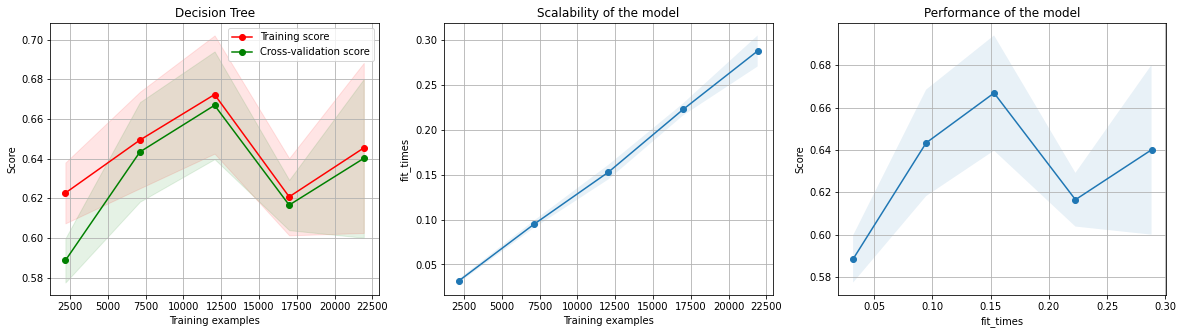

In [295]:
title = 'Decision Tree'
plot_learning_curve(dt_3, title, X[dt_best], Y,
                    cv=5, n_jobs=-1)
plt.show()

In [296]:
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_3,X=X[dt_best],y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.74


best_features_logit:  Index(['ARV17_MINUS_ARV16', 'AXM4970T', 'AXM5030T', 'BKRPT_RCV_SCORE_VALUE',
       'BRC4012T', 'BRC5030T', 'BRC8131T', 'CUNSBAL_V1', 'CUNSINQ_V1', 'DEM05',
       'SCR02', 'SCR16', 'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL24',
       'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_AAU13',
       'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19', 'SMARTV40_ABK21',
       'SMARTV40_ABK22', 'SMARTV40_ABK23', 'SMARTV40_AIN17', 'SMARTV40_ALN12',
       'SMARTV40_ALN13', 'SMARTV40_AMG13', 'SMARTV40_ART17', 'SMARTV40_ART18',
       'SMARTV40_ART23', 'SMARTV40_ARV16', 'SMARTV40_ARV31', 'SMARTV40_ARV34'],
      dtype='object') 



100%|===================| 41053/41108 [05:11<00:00]       

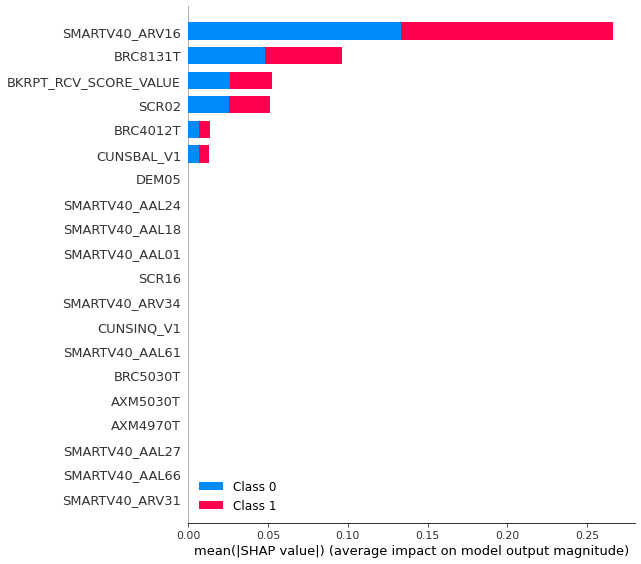

In [297]:
print('best_features_logit: ', dt_best, '\n')
shap_values = shap.TreeExplainer(dt_3, X[dt_best]).shap_values(X0[dt_best])
shap.summary_plot(shap_values, X0[dt_best])

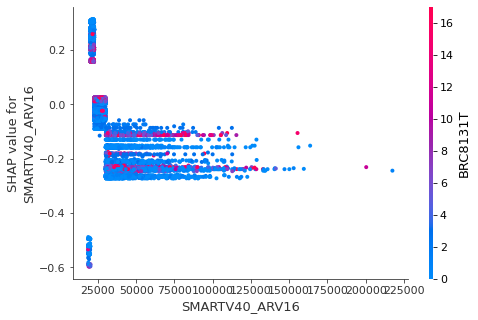

In [298]:
shap.dependence_plot('SMARTV40_ARV16', shap_values[0], X0[dt_best])

# **Random Forest**

In [341]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

rf_1 = RandomForestClassifier(class_weight='balanced',max_depth=14,min_samples_leaf=124, random_state=42).fit(X0,Y0)
model_performance(X0, X1, Y0, Y1, rf_1)


ROC AUC Train 0.793
ROC AUC Test 0.74
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     17137
           1       0.35      0.69      0.46      3417

    accuracy                           0.73     20554
   macro avg       0.64      0.72      0.64     20554
weighted avg       0.83      0.73      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      5701
           1       0.31      0.61      0.41      1151

    accuracy                           0.71      6852
   macro avg       0.61      0.67      0.61      6852
weighted avg       0.80      0.71      0.74      6852

-------------------------


In [0]:
rf_best = best_features(RandomForestClassifier(class_weight='balanced', random_state=42), 35, X0, Y0)

In [343]:
rf_best

Index(['ARV17_MINUS_ARV16', 'AXM5030T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T',
       'BRC4016T', 'BRC4971T', 'BRC5030T', 'BRC8131T', 'CUNSINQ_V1', 'DEM05',
       'SCR02', 'SCR16', 'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL24',
       'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_AAU13',
       'SMARTV40_ABK01', 'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19',
       'SMARTV40_ABK21', 'SMARTV40_ABK22', 'SMARTV40_ABK23', 'SMARTV40_AIN17',
       'SMARTV40_ALN12', 'SMARTV40_ART17', 'SMARTV40_ART18', 'SMARTV40_ART23',
       'SMARTV40_ARV16', 'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34'],
      dtype='object')

In [0]:
rf_best_save = ['ARV17_MINUS_ARV16', 'AXM5030T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4012T',
       'BRC4016T', 'BRC4971T', 'BRC5030T', 'BRC8131T', 'CUNSINQ_V1', 'DEM05',
       'SCR02', 'SCR16', 'SMARTV40_AAL01', 'SMARTV40_AAL18', 'SMARTV40_AAL24',
       'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66', 'SMARTV40_AAU13',
       'SMARTV40_ABK01', 'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19',
       'SMARTV40_ABK21', 'SMARTV40_ABK22', 'SMARTV40_ABK23', 'SMARTV40_AIN17',
       'SMARTV40_ALN12', 'SMARTV40_ART17', 'SMARTV40_ART18', 'SMARTV40_ART23',
       'SMARTV40_ARV16', 'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34']

In [344]:
rf_2 = RandomForestClassifier(class_weight='balanced',max_depth=14,min_samples_leaf=124, random_state=42).fit(X0[rf_best],Y0)
model_performance(X0[rf_best], X1[rf_best], Y0, Y1, rf_2)


ROC AUC Train 0.79
ROC AUC Test 0.74
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.92      0.74      0.82     17137
           1       0.35      0.69      0.46      3417

    accuracy                           0.73     20554
   macro avg       0.63      0.71      0.64     20554
weighted avg       0.83      0.73      0.76     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      5701
           1       0.31      0.61      0.41      1151

    accuracy                           0.71      6852
   macro avg       0.61      0.67      0.61      6852
weighted avg       0.80      0.71      0.74      6852

-------------------------


In [345]:
param_rf = {'class_weight': [None, 'balanced'],'max_depth': range(9,15),
          'min_samples_leaf': range(0,200,15)
          }

gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_dt, scoring="roc_auc", cv=5, n_jobs=-1,verbose=1)
gs_rf.fit(X0,Y0)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [347]:
gs_rf.best_params_

{'max_depth': 8, 'min_samples_leaf': 30}

In [361]:
rf_3 = RandomForestClassifier(class_weight='balanced',max_depth=8,min_samples_leaf=30, random_state=42,n_estimators=750,max_leaf_nodes=18,min_samples_split=30).fit(X0[rf_best],Y0)
model_performance(X0[rf_best], X1[rf_best], Y0, Y1, rf_3)


ROC AUC Train 0.758
ROC AUC Test 0.739
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.91      0.72      0.81     17137
           1       0.32      0.66      0.43      3417

    accuracy                           0.71     20554
   macro avg       0.62      0.69      0.62     20554
weighted avg       0.81      0.71      0.74     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      5701
           1       0.31      0.62      0.41      1151

    accuracy                           0.70      6852
   macro avg       0.61      0.67      0.61      6852
weighted avg       0.80      0.70      0.74      6852

-------------------------


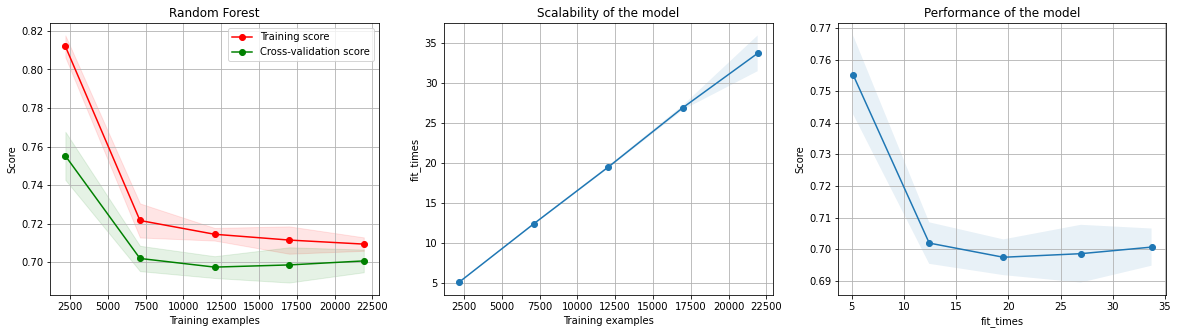

In [362]:
title = 'Random Forest'
plot_learning_curve(rf_3, title, X[rf_best], Y,
                    cv=5, n_jobs=-1)
plt.show()

In [363]:
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_3,X=X[rf_best],y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned RF 0.74


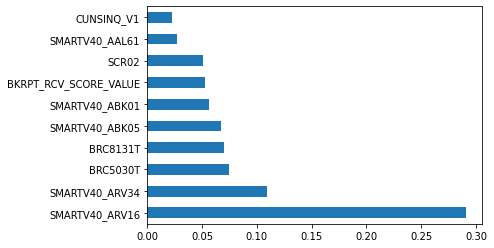

In [364]:
feat_importances = pd.Series(rf_3.feature_importances_, index=rf_best)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [0]:
# shap_values = shap.TreeExplainer(rf_3, X[rf_best]).shap_values(X0[rf_best])
# shap.summary_plot(shap_values, X0[rf_best])

# **Gradient Boosting Test**

In [0]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

# lr: 0.8, n_estimators: 300

gb_1 = GradientBoostingClassifier(loss= 'deviance', max_depth = 3, min_samples_split=2, n_estimators=300, 
                                  learning_rate= 0.08, random_state=42).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_1)


ROC AUC Train 0.852
ROC AUC Test 0.791
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     17137
           1       0.82      0.25      0.38      3417

    accuracy                           0.87     20554
   macro avg       0.84      0.62      0.65     20554
weighted avg       0.86      0.87      0.83     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      5701
           1       0.63      0.18      0.28      1151

    accuracy                           0.84      6852
   macro avg       0.74      0.58      0.60      6852
weighted avg       0.82      0.84      0.81      6852

-------------------------


In [0]:
gb_best = best_features(GradientBoostingClassifier(random_state=42,max_depth = 3, 
                                                   min_samples_split=2, n_estimators=50, 
                                                   learning_rate= 0.08, verbose=1), 40, X0, Y0)

In [0]:
gb_best

Index(['ARV17_MINUS_ARV16', 'AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4003T',
       'BRC4012T', 'BRC4016T', 'BRC4970T', 'BRC5030T', 'BRC8131T',
       'CUNSAGE_V1', 'CUNSBAL_V1', 'CUNSINQ_V1', 'SCR02', 'SMARTV40_AAL18',
       'SMARTV40_AAL24', 'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66',
       'SMARTV40_ABK01', 'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19',
       'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_AIQ01', 'SMARTV40_ALN12',
       'SMARTV40_APR30', 'SMARTV40_APR35', 'SMARTV40_ARV15', 'SMARTV40_ARV16',
       'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34', 'SMARTV40_ASL09',
       'SMARTV40_DDT02', 'SMARTV40_AAU20_6', 'STATE_CD_CA', 'STATE_CD_MS',
       'STATE_CD_PA', 'STATE_CD_SC'],
      dtype='object')

In [0]:
# After 30m, I better save the results
['ARV17_MINUS_ARV16', 'AXM8131T', 'BKRPT_RCV_SCORE_VALUE', 'BRC4003T',
       'BRC4012T', 'BRC4016T', 'BRC4970T', 'BRC5030T', 'BRC8131T',
       'CUNSAGE_V1', 'CUNSBAL_V1', 'CUNSINQ_V1', 'SCR02', 'SMARTV40_AAL18',
       'SMARTV40_AAL24', 'SMARTV40_AAL27', 'SMARTV40_AAL61', 'SMARTV40_AAL66',
       'SMARTV40_ABK01', 'SMARTV40_ABK05', 'SMARTV40_ABK18', 'SMARTV40_ABK19',
       'SMARTV40_ABK21', 'SMARTV40_ABK23', 'SMARTV40_AIQ01', 'SMARTV40_ALN12',
       'SMARTV40_APR30', 'SMARTV40_APR35', 'SMARTV40_ARV15', 'SMARTV40_ARV16',
       'SMARTV40_ARV23', 'SMARTV40_ARV31', 'SMARTV40_ARV34', 'SMARTV40_ASL09',
       'SMARTV40_DDT02', 'SMARTV40_AAU20_6', 'STATE_CD_CA', 'STATE_CD_MS',
       'STATE_CD_PA', 'STATE_CD_SC']

In [0]:
gb_2 = GradientBoostingClassifier(loss= 'deviance',max_depth=3,min_samples_split=2, random_state=42, 
                                   n_estimators = 300, learning_rate= 0.08).fit(X0[gb_best],Y0)

model_performance(X0[gb_best], X1[gb_best], Y0, Y1, gb_2)


ROC AUC Train 0.844
ROC AUC Test 0.787
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     17137
           1       0.81      0.25      0.38      3417

    accuracy                           0.86     20554
   macro avg       0.84      0.62      0.65     20554
weighted avg       0.86      0.86      0.83     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5701
           1       0.61      0.18      0.27      1151

    accuracy                           0.84      6852
   macro avg       0.73      0.58      0.59      6852
weighted avg       0.81      0.84      0.80      6852

-------------------------


In [0]:
param_gb = { "max_depth":range(2,7),
            'min_samples_split': range(1, 10, 1)
            }

gs_gb = GridSearchCV(estimator=GradientBoostingClassifier(loss= 'deviance',
                                                          n_estimators=70, 
                                                          learning_rate= 0.08,
                                                          random_state=42),             
                   param_grid=param_gb, scoring="roc_auc", cv=3, n_jobs=-1, verbose=1)
gs_gb.fit(X0[gb_best],Y0)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 10.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.08,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=70,
                                                  n_iter_no_change=None,
         

In [0]:
gs_gb.best_params_ # {'max_depth': 4, 'min_samples_split': 7}

{'max_depth': 4, 'min_samples_split': 7}

In [0]:
gb_3 = GradientBoostingClassifier(loss= 'deviance',max_depth=3,min_samples_split=2, random_state=42, 
                                   n_estimators = 410, learning_rate= 0.016).fit(X0[gb_best],Y0)

model_performance(X0[gb_best], X1[gb_best], Y0, Y1, gb_3)


ROC AUC Train 0.804
ROC AUC Test 0.784
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     17137
           1       0.76      0.15      0.25      3417

    accuracy                           0.85     20554
   macro avg       0.80      0.57      0.58     20554
weighted avg       0.84      0.85      0.81     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5701
           1       0.67      0.13      0.22      1151

    accuracy                           0.84      6852
   macro avg       0.76      0.56      0.57      6852
weighted avg       0.82      0.84      0.80      6852

-------------------------


In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_3,X=X[gb_best],y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned GB 0.78


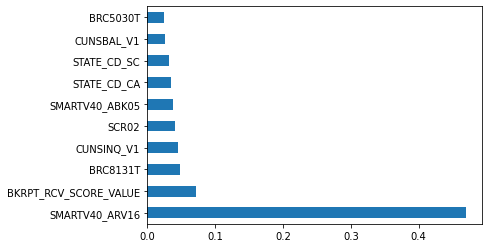

In [0]:
feat_importances = pd.Series(gb_3.feature_importances_, index=gb_best)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [0]:
# shap_values = shap.TreeExplainer(gb_1, X[gb_best]).shap_values(X0[gb_best])
# shap.summary_plot(shap_values, X0[gb_best])

# **Final Model**

In [0]:
X, Y = get_target_and_features(clean_data(data,cleanup_methods[8]))
# Feature Engineering
X0, X1, Y0, Y1 = tt_split_results(X, Y)

gb_final = GradientBoostingClassifier(loss= 'deviance', max_depth = 3, min_samples_split=2, n_estimators=300, 
                                  learning_rate= 0.08, random_state=42).fit(X0,Y0)

model_performance(X0, X1, Y0, Y1, gb_final)


ROC AUC Train 0.852
ROC AUC Test 0.791
-------------------------

Classification Report Train
              precision    recall  f1-score   support

           0       0.87      0.99      0.92     17137
           1       0.82      0.25      0.38      3417

    accuracy                           0.87     20554
   macro avg       0.84      0.62      0.65     20554
weighted avg       0.86      0.87      0.83     20554

-------------------------

Classification Report Test
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      5701
           1       0.63      0.18      0.28      1151

    accuracy                           0.84      6852
   macro avg       0.74      0.58      0.60      6852
weighted avg       0.82      0.84      0.81      6852

-------------------------


In [0]:
print("Mean 5-fold ROC AUC score for Tuned GB",np.mean(cross_val_score(estimator=gb_final,X=X,
                                                                       y=Y,cv=5, scoring="roc_auc")).round(3))

Mean 5-fold ROC AUC score for Tuned GB 0.786


# **Model Interpretation**

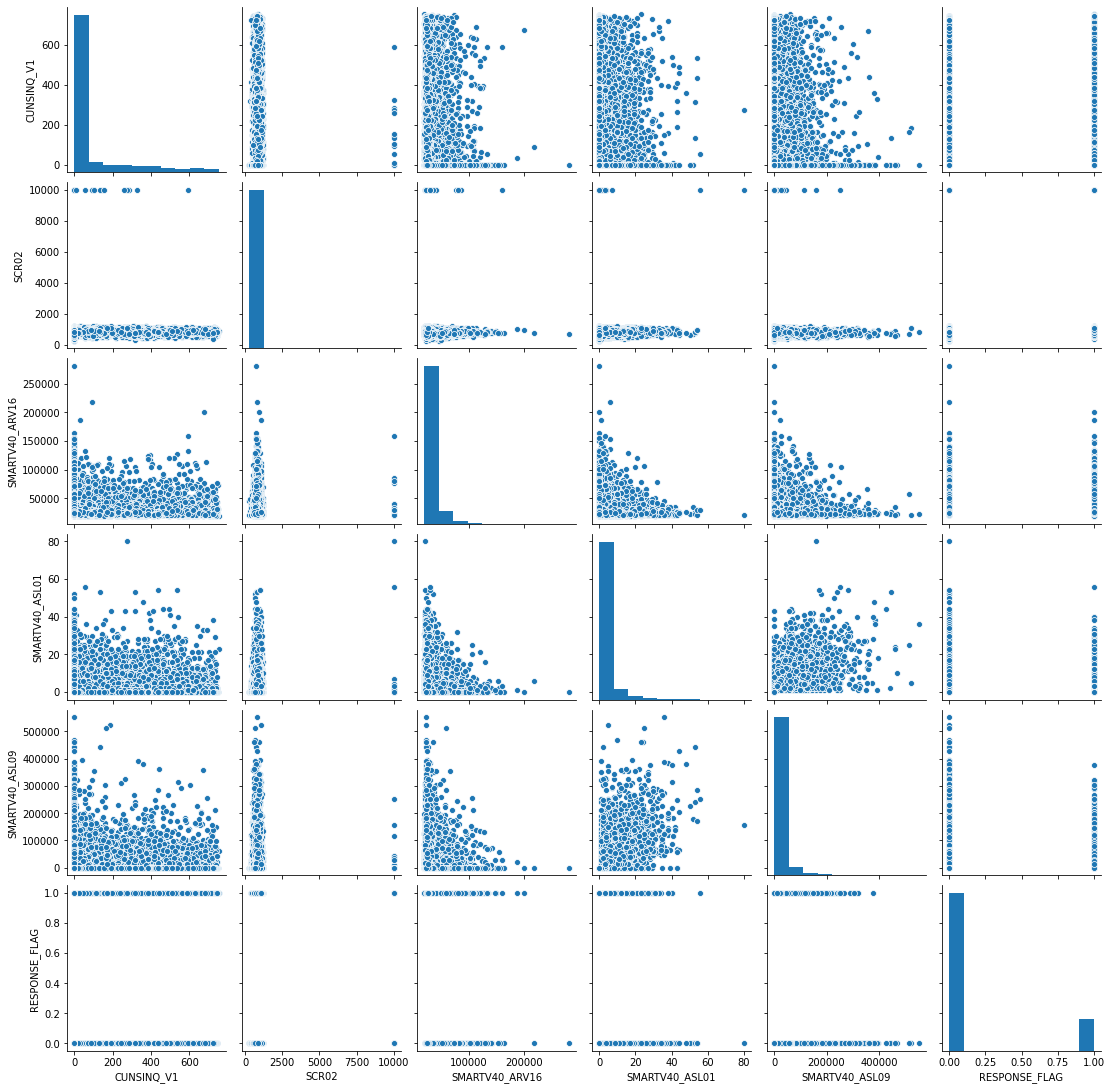

In [0]:
sns.pairplot(clean_data(data,cleanup_methods[8])[['CUNSINQ_V1', 'SCR02', 'SMARTV40_ARV16', 
                     'SMARTV40_ASL01','SMARTV40_ASL09', 'RESPONSE_FLAG']])
plt.show()

In [0]:
print(logit_model_statsmodels.summary())

                           Logit Regression Results                           
Dep. Variable:          RESPONSE_FLAG   No. Observations:                20554
Model:                          Logit   Df Residuals:                    20389
Method:                           MLE   Df Model:                          164
Date:                Mon, 18 May 2020   Pseudo R-squ.:                  0.1120
Time:                        02:27:56   Log-Likelihood:                -8211.5
converged:                      False   LL-Null:                       -9246.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1545.6149        nan        nan        nan         nan         nan
ARV17_MINUS_ARV16     -1.065e-05    4.1e-06     -2.598      0.009   -1.87e-05   -2.62e-06
AXM4970T

# **ROC Curve**

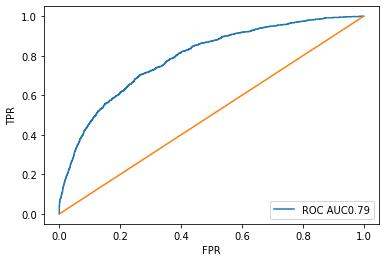

In [0]:
FPR, TPR, thresholds = roc_curve(Y1, gb_final.predict_proba(X1)[:,1])
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1,gb_final.predict_proba(X1)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# **Gain Curve**

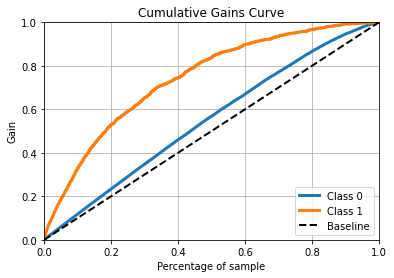

In [0]:
skplt.metrics.plot_cumulative_gain(Y1,gb_final.predict_proba(X1))
plt.show()

# **Lift Curve**

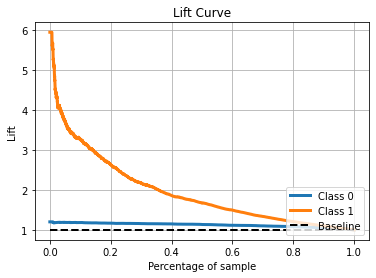

In [0]:
skplt.metrics.plot_lift_curve(Y1,gb_final.predict_proba(X1))
plt.show()